In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
here = 'colab'
# here = 'kaggle'

if here=='colab':
    import sys
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01') # py 파일이 있는 filepath
    from DACON_pj01 import myOverfitting, mySetting, myTrain
    data_path = '/content/drive/MyDrive/Colab Notebooks/DACON_pj01_data'
    output_fp = '/content/drive/MyDrive/Colab Notebooks/selfDACON_pj01/output/'
elif here=='kaggle':
    data_path = '/kaggle/input/remodel' 
    output_fp = '/kaggle/working/' 

In [3]:
import random
import pandas as pd
import numpy as np
import os, re, glob, cv2
from PIL import Image 
import matplotlib.pyplot as plt
# plt.rc('font', family='NanumBarunGothic')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data import Subset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
from copy import deepcopy

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
setting = mySetting(seed=41)
setting.seedSetting() # seed 고정

### 1. 데이터 전처리

In [ ]:
# overfit = myOverfitting(data_path, cutline=100)
# overfit.increase_data()

0   가구수정 : 12
4   녹오염  : 14
5   들뜸    : 54
6   면불량 : 99
8   반점    : 3
9   석고수정: 57
12  울음    : 22
13  이음부불량: 17
14  창틀,문틀수정: 27
16  틈새과다 : 5
17  피스      : 51


In [ ]:
setting.getDataframe(data_path, valid_s=0.2)
print(setting.train_df['label'].value_counts())

transform = A.Compose([A.Resize(224,224),
                       A.CLAHE(tile_grid_size=(6,6), p=0.3),
                       A.HorizontalFlip(p=0.3),
                       A.RandomBrightnessContrast(p=0.3),
                       A.Normalize(),
                       ToTensorV2()])
test_transform = A.Compose([A.Resize(224,224),
                            A.Normalize(),
                            ToTensorV2()])
setting.getDataset(transform, test_transform, using='A')

batch_s = 10
setting.getDataloader(batch_s)

18    1124
10     476
1      245
3      168
15     129
2      116
11     114
7      104
0       80
5       80
9       80
6       80
16      80
13      80
14      80
8       80
12      80
17      80
4       80
Name: label, dtype: int64
train, valid, test: 3356 840 792
train, valid, test: 336 84 80
trainloader shape torch.Size([10, 3, 224, 224]) torch.Size([10])


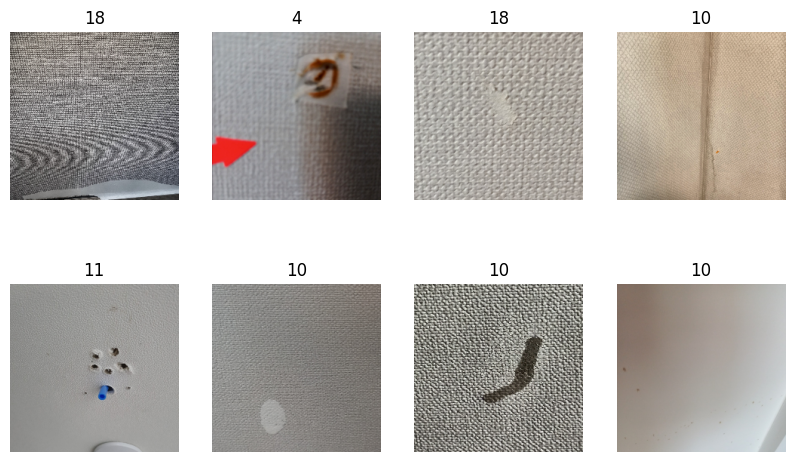

{1: '걸레받이수정', 0: '가구수정', 2: '곰팡이', 3: '꼬임', 4: '녹오염', 5: '들뜸', 6: '면불량', 7: '몰딩수정', 9: '석고수정', 8: '반점', 11: '오타공', 10: '오염', 12: '울음', 18: '훼손', 16: '틈새과다', 14: '창틀,문틀수정', 17: '피스', 13: '이음부불량', 15: '터짐'}


In [ ]:
setting.showimg()
print(setting.labels_map)

### 2. model 설정

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=b9e67648691ffd0377f4a3ddb6926154ade20ece0fa35589183db0424e8bf642
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch


In [ ]:
def load_model(name, output_s, opt=True, lock1=False, lock2=True):
    if name == 'resNet152':
        model = models.resnet152(weights=True)
        for parameter in model.parameters():
            parameter.requires_grad = lock1
        for parameter in model.fc.parameters(): 
            parameter.requires_grad = lock2
        if opt:
            model.fc = nn.Sequential(nn.Linear(2048,512), nn.BatchNorm1d(512), nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(512,256), nn.BatchNorm1d(256), nn.ReLU(),
                                nn.Linear(256,output_s)) # 19
        else: model.fc = nn.Linear(2048, output_s)
    elif name == 'effiNet-b5':
        model = EfficientNet.from_pretrained('efficientnet-b5', num_classes=output_s)
        for parameter in model.parameters():
            parameter.requires_grad = lock1
        for parameter in model._fc.parameters(): 
            parameter.requires_grad = lock2
        if opt: 
            model._fc = nn.Sequential(nn.Linear(2048,512), nn.BatchNorm1d(512), nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(512,256), nn.BatchNorm1d(256), nn.ReLU(),
                                nn.Linear(256,output_s)) # 19
    return model

checkmodel = load_model('effiNet-b5', len(setting.le.classes_), opt=True)
checkmodel._fc

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:01<00:00, 73.2MB/s]


Loaded pretrained weights for efficientnet-b5


Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=256, out_features=19, bias=True)
)

### 3. 학습

In [ ]:
date = '0426'
submit = pd.read_csv(data_path+'/sample_submission.csv')

- lr=0.001, bs=12, model=effi-b5, trans=resize(224)

train, valid, test: 280 70 66
trainloader shape torch.Size([12, 3, 224, 224]) torch.Size([12])
Loaded pretrained weights for efficientnet-b5


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 2/30....... Train Loss : 1.764 Valid Loss : 1.314 Valid F1 Score : 0.553


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 3/30....... Train Loss : 1.286 Valid Loss : 1.162 Valid F1 Score : 0.598


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 4/30....... Train Loss : 1.153 Valid Loss : 1.140 Valid F1 Score : 0.594


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 5/30....... Train Loss : 1.059 Valid Loss : 1.066 Valid F1 Score : 0.605


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 6/30....... Train Loss : 0.954 Valid Loss : 1.047 Valid F1 Score : 0.641


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 7/30....... Train Loss : 0.916 Valid Loss : 1.029 Valid F1 Score : 0.654


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 8/30....... Train Loss : 0.878 Valid Loss : 1.025 Valid F1 Score : 0.647


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 9/30....... Train Loss : 0.831 Valid Loss : 1.007 Valid F1 Score : 0.658


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 10/30....... Train Loss : 0.822 Valid Loss : 0.984 Valid F1 Score : 0.656


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 11/30....... Train Loss : 0.741 Valid Loss : 0.970 Valid F1 Score : 0.655


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 12/30....... Train Loss : 0.752 Valid Loss : 0.963 Valid F1 Score : 0.672


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 13/30....... Train Loss : 0.706 Valid Loss : 0.991 Valid F1 Score : 0.671


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 14/30....... Train Loss : 0.700 Valid Loss : 0.941 Valid F1 Score : 0.686


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 15/30....... Train Loss : 0.682 Valid Loss : 0.975 Valid F1 Score : 0.665


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 16/30....... Train Loss : 0.641 Valid Loss : 0.944 Valid F1 Score : 0.687


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 17/30....... Train Loss : 0.634 Valid Loss : 0.910 Valid F1 Score : 0.694


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 18/30....... Train Loss : 0.618 Valid Loss : 0.932 Valid F1 Score : 0.681


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 19/30....... Train Loss : 0.606 Valid Loss : 1.016 Valid F1 Score : 0.659


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 20/30....... Train Loss : 0.585 Valid Loss : 1.005 Valid F1 Score : 0.664
Epoch 00019: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 21/30....... Train Loss : 0.527 Valid Loss : 0.948 Valid F1 Score : 0.694


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 22/30....... Train Loss : 0.504 Valid Loss : 0.925 Valid F1 Score : 0.696


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 23/30....... Train Loss : 0.490 Valid Loss : 0.927 Valid F1 Score : 0.685


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 24/30....... Train Loss : 0.483 Valid Loss : 0.926 Valid F1 Score : 0.686


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 25/30....... Train Loss : 0.485 Valid Loss : 0.913 Valid F1 Score : 0.711


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 26/30....... Train Loss : 0.472 Valid Loss : 0.922 Valid F1 Score : 0.704


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 27/30....... Train Loss : 0.446 Valid Loss : 0.935 Valid F1 Score : 0.711


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 28/30....... Train Loss : 0.458 Valid Loss : 0.914 Valid F1 Score : 0.706


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 29/30....... Train Loss : 0.456 Valid Loss : 0.894 Valid F1 Score : 0.722


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 30/30....... Train Loss : 0.438 Valid Loss : 0.921 Valid F1 Score : 0.705


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch : 31/30....... Train Loss : 0.461 Valid Loss : 0.909 Valid F1 Score : 0.698


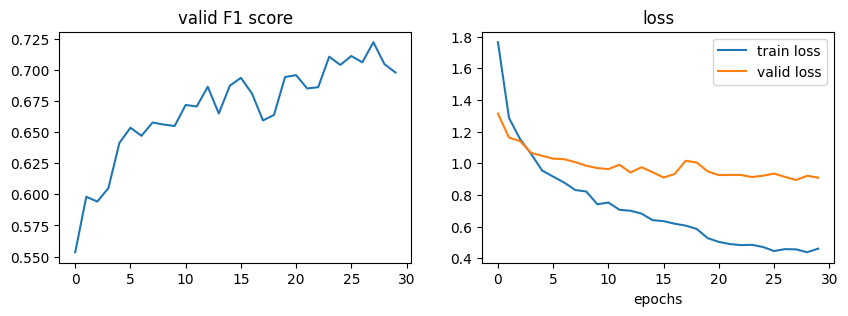

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
batch_s = 12
setting.getDataloader(batch_s)
model = load_model('effiNet-b5', len(setting.le.classes_), opt=True)
lr = 0.001; patience = 7; epochs = 30
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr) 
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

myNN = myTrain(model, loss_fn, optimizer, setting.trainloader, setting.validloader, setting.testloader, 
             scheduler, device, setting.le, epochs, patience, batch_s)
myNN.train_loop()
myNN.result_plot()
torch.save(myNN.model.state_dict(), 'last_checkpoint.pth')
test_preds = myNN.evaluate(myNN.model, myNN.testloader, myNN.loss_fn)
last_preds = myNN.load_model('last_checkpoint.pth', model, setting.testloader, loss_fn)
if len(myNN.validloader)!=0:
    best_preds = myNN.load_model('best_checkpoint.pth', model, setting.testloader, loss_fn)
    preds_li = [test_preds, last_preds, best_preds]
else: preds_li = [test_preds, last_preds]
date_n = date
myNN.save_preds(submit, output_fp, date_n, preds_li)

- lr=0.001, bs=10, model=effi-b5, trans=resize(224)

train, valid, test: 336 84 80
trainloader shape torch.Size([10, 3, 224, 224]) torch.Size([10])
Loaded pretrained weights for efficientnet-b5


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 2/30....... Train Loss : 1.807 Valid Loss : 1.334 Valid F1 Score : 0.517


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 3/30....... Train Loss : 1.348 Valid Loss : 1.254 Valid F1 Score : 0.576


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 4/30....... Train Loss : 1.183 Valid Loss : 1.206 Valid F1 Score : 0.579


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 5/30....... Train Loss : 1.078 Valid Loss : 1.100 Valid F1 Score : 0.611


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 6/30....... Train Loss : 1.041 Valid Loss : 1.120 Valid F1 Score : 0.599


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 7/30....... Train Loss : 0.948 Valid Loss : 1.118 Valid F1 Score : 0.605


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 8/30....... Train Loss : 0.901 Valid Loss : 1.053 Valid F1 Score : 0.636


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 9/30....... Train Loss : 0.883 Valid Loss : 1.029 Valid F1 Score : 0.636


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 10/30....... Train Loss : 0.862 Valid Loss : 1.036 Valid F1 Score : 0.648


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 11/30....... Train Loss : 0.832 Valid Loss : 1.037 Valid F1 Score : 0.634


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 12/30....... Train Loss : 0.785 Valid Loss : 0.986 Valid F1 Score : 0.662


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 13/30....... Train Loss : 0.744 Valid Loss : 1.003 Valid F1 Score : 0.648


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 14/30....... Train Loss : 0.723 Valid Loss : 1.068 Valid F1 Score : 0.637


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 15/30....... Train Loss : 0.715 Valid Loss : 1.016 Valid F1 Score : 0.670


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 16/30....... Train Loss : 0.701 Valid Loss : 1.067 Valid F1 Score : 0.635


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 17/30....... Train Loss : 0.644 Valid Loss : 1.052 Valid F1 Score : 0.648


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 18/30....... Train Loss : 0.665 Valid Loss : 1.084 Valid F1 Score : 0.657
Epoch 00017: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 19/30....... Train Loss : 0.603 Valid Loss : 0.992 Valid F1 Score : 0.659


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 20/30....... Train Loss : 0.555 Valid Loss : 0.970 Valid F1 Score : 0.671


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 21/30....... Train Loss : 0.540 Valid Loss : 0.973 Valid F1 Score : 0.697


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 22/30....... Train Loss : 0.521 Valid Loss : 0.963 Valid F1 Score : 0.678


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 23/30....... Train Loss : 0.520 Valid Loss : 1.058 Valid F1 Score : 0.646


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 24/30....... Train Loss : 0.479 Valid Loss : 0.968 Valid F1 Score : 0.670
Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 25/30....... Train Loss : 0.471 Valid Loss : 1.001 Valid F1 Score : 0.656


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 26/30....... Train Loss : 0.416 Valid Loss : 1.014 Valid F1 Score : 0.660


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 27/30....... Train Loss : 0.429 Valid Loss : 0.967 Valid F1 Score : 0.685
Epoch 00026: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 28/30....... Train Loss : 0.419 Valid Loss : 1.030 Valid F1 Score : 0.671


  0%|          | 0/336 [00:00<?, ?it/s]

Epoch : 29/30....... Train Loss : 0.418 Valid Loss : 0.972 Valid F1 Score : 0.674

Early Stopping!! epoch/epochs: 28/30


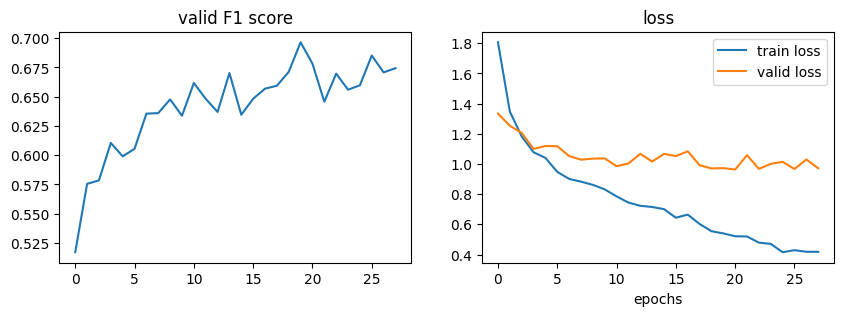

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
batch_s = 10
setting.getDataloader(batch_s)
model2 = load_model('effiNet-b5', len(setting.le.classes_), opt=True)
lr = 0.001; patience = 7; epochs = 30
model2 = model2.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model2.parameters(), lr=lr) 
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, 
                                                       threshold_mode='abs', min_lr=1e-8, verbose=True)

myNN2 = myTrain(model2, loss_fn, optimizer, setting.trainloader, setting.validloader, setting.testloader, 
             scheduler, device, setting.le, epochs, patience, batch_s)
myNN2.train_loop()
myNN2.result_plot()
torch.save(myNN2.model.state_dict(), 'last_checkpoint.pth')
test_preds2 = myNN2.evaluate(myNN2.model, myNN2.testloader, myNN2.loss_fn)
last_preds2 = myNN2.load_model('last_checkpoint.pth', model2, setting.testloader, loss_fn)
if len(myNN2.validloader)!=0:
    best_preds2 = myNN2.load_model('best_checkpoint.pth', model2, setting.testloader, loss_fn)
    preds_li2 = [test_preds2, last_preds2, best_preds2]
else: preds_li2 = [test_preds2, last_preds2]
date_n = date+'_2'
myNN2.save_preds(submit, output_fp, date_n, preds_li2)

- lr=0.001, bs=8, model=effi-b5, trans=resize(224)

train, valid, test: 420 105 99
trainloader shape torch.Size([8, 3, 224, 224]) torch.Size([8])
Loaded pretrained weights for efficientnet-b5


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 2/30....... Train Loss : 1.804 Valid Loss : 1.387 Valid F1 Score : 0.542


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 3/30....... Train Loss : 1.367 Valid Loss : 1.316 Valid F1 Score : 0.531


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 4/30....... Train Loss : 1.215 Valid Loss : 1.229 Valid F1 Score : 0.572


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 5/30....... Train Loss : 1.101 Valid Loss : 1.217 Valid F1 Score : 0.584


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 6/30....... Train Loss : 1.055 Valid Loss : 1.131 Valid F1 Score : 0.596


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 7/30....... Train Loss : 0.984 Valid Loss : 1.151 Valid F1 Score : 0.615


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 8/30....... Train Loss : 0.952 Valid Loss : 1.086 Valid F1 Score : 0.616


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 9/30....... Train Loss : 0.891 Valid Loss : 1.072 Valid F1 Score : 0.636


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 10/30....... Train Loss : 0.866 Valid Loss : 1.105 Valid F1 Score : 0.626


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 11/30....... Train Loss : 0.847 Valid Loss : 1.072 Valid F1 Score : 0.639


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 12/30....... Train Loss : 0.806 Valid Loss : 1.168 Valid F1 Score : 0.619


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 13/30....... Train Loss : 0.797 Valid Loss : 1.062 Valid F1 Score : 0.625


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 14/30....... Train Loss : 0.751 Valid Loss : 1.100 Valid F1 Score : 0.623
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 15/30....... Train Loss : 0.668 Valid Loss : 1.066 Valid F1 Score : 0.647


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 16/30....... Train Loss : 0.647 Valid Loss : 1.061 Valid F1 Score : 0.639


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 17/30....... Train Loss : 0.609 Valid Loss : 1.087 Valid F1 Score : 0.638


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 18/30....... Train Loss : 0.600 Valid Loss : 1.040 Valid F1 Score : 0.663


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 19/30....... Train Loss : 0.593 Valid Loss : 1.000 Valid F1 Score : 0.656


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 20/30....... Train Loss : 0.588 Valid Loss : 1.018 Valid F1 Score : 0.657


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 21/30....... Train Loss : 0.569 Valid Loss : 1.105 Valid F1 Score : 0.649
Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 22/30....... Train Loss : 0.586 Valid Loss : 1.007 Valid F1 Score : 0.668


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 23/30....... Train Loss : 0.569 Valid Loss : 1.042 Valid F1 Score : 0.651


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 24/30....... Train Loss : 0.581 Valid Loss : 0.999 Valid F1 Score : 0.671


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 25/30....... Train Loss : 0.560 Valid Loss : 0.994 Valid F1 Score : 0.680


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 26/30....... Train Loss : 0.566 Valid Loss : 1.048 Valid F1 Score : 0.648


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 27/30....... Train Loss : 0.564 Valid Loss : 1.017 Valid F1 Score : 0.654


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 28/30....... Train Loss : 0.540 Valid Loss : 1.010 Valid F1 Score : 0.653
Epoch 00027: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 29/30....... Train Loss : 0.555 Valid Loss : 1.065 Valid F1 Score : 0.652


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 30/30....... Train Loss : 0.541 Valid Loss : 1.004 Valid F1 Score : 0.680


  0%|          | 0/420 [00:00<?, ?it/s]

Epoch : 31/30....... Train Loss : 0.538 Valid Loss : 1.049 Valid F1 Score : 0.640


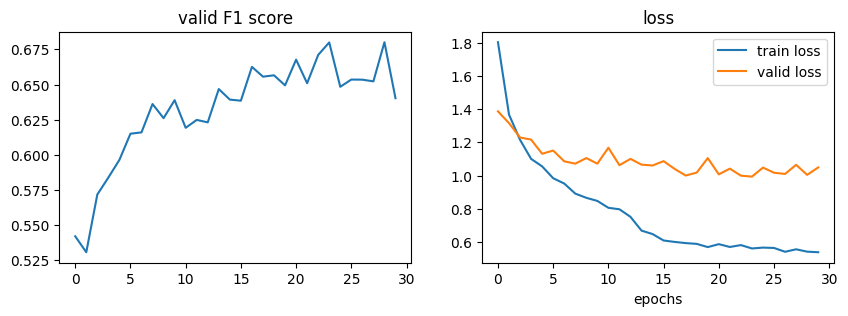

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
batch_s = 8
setting.getDataloader(batch_s)
model3 = load_model('effiNet-b5', len(setting.le.classes_), opt=True)
lr = 0.001; patience = 7; epochs = 30
model3 = model3.to(device)
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model3.parameters(), lr=lr) 
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, 
#                                                        threshold_mode='abs', min_lr=1e-8, verbose=True)

myNN3 = myTrain(model3, loss_fn, optimizer, setting.trainloader, setting.validloader, setting.testloader, 
             scheduler, device, setting.le, epochs, patience, batch_s)
myNN3.train_loop()
myNN3.result_plot()
torch.save(myNN3.model.state_dict(), 'last_checkpoint.pth')
test_preds3 = myNN3.evaluate(myNN3.model, myNN3.testloader, myNN3.loss_fn)
last_preds3 = myNN3.load_model('last_checkpoint.pth', model3, setting.testloader, loss_fn)
if len(myNN3.validloader)!=0:
    best_preds3 = myNN3.load_model('best_checkpoint.pth', model3, setting.testloader, loss_fn)
    preds_li3 = [test_preds3, last_preds3, best_preds3]
else: preds_li3 = [test_preds3, last_preds3]
date_n = date+'_3'
myNN3.save_preds(submit, output_fp, date_n, preds_li3)

In [ ]:
class myOverfitting():
    def __init__(self, data_path, cutline=30):
        self.data_path = data_path
        self.cutline = cutline
        self.choose_small_data()
    
    def choose_small_data(self):
        df = pd.DataFrame(data={'img_path':glob.glob(self.data_path+'/train/*/*')})
        df['label'] = df['img_path'].apply(lambda x: str(x).split('/')[-2])
        le = LabelEncoder()
        df['label'] = le.fit_transform(df['label'])
        self.overs_dic = {}
        for i, name in zip(range(len(le.classes_)), le.classes_):
            if df['label'].value_counts()[i]<=self.cutline:
                print('{0:<3} {1:<10}: {2}'.format(i, name, df['label'].value_counts()[i]))
                self.overs_dic[name] = glob.glob(self.data_path+'/train/'+name+'/*')
        return self
                
    def increase_data(self):
        for k,v in self.overs_dic.items():
            increase_num = self.cutline - len(v)
            self.overs_dic[k] = v*(increase_num//len(v)) + v[:increase_num%len(v)]
            for i, img_path in enumerate(self.overs_dic[k]):
                img = np.array(Image.open(img_path).convert('RGB'))
                flip, rnd_n = np.random.randint(0,2), np.random.randint(0,7)
                if flip: img = cv2.flip(img, 1)

                h,w = img.shape[:2]
                dst_pts = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], dtype=np.float32)
                if rnd_n==0: img_pts = np.array([[15,15],[w-15,15],[w-15,h-15],[15,h-15]], dtype=np.float32)
                elif rnd_n==1: img_pts = np.array([[30,0],[w-1,0],[w-1,h-1],[30,h-1]], dtype=np.float32)
                elif rnd_n==2: img_pts = np.array([[0,25],[w-1,25],[w-1,h-1],[0,h-1]], dtype=np.float32)
                elif rnd_n==3: img_pts = np.array([[0,0],[w-30,0],[w-30,h-1],[0,h-1]], dtype=np.float32)
                elif rnd_n==4: img_pts = np.array([[0,0],[w-1,0],[w-1,h-25],[0,h-25]], dtype=np.float32)
                elif rnd_n==5: img_pts = np.array([[30,0],[w-20,40],[w-10,h-10],[5,h-20]], dtype=np.float32)
                elif rnd_n==6: img_pts = np.array([[40,10],[w-15,20],[w-30,h-20],[15,h-10]], dtype=np.float32)
                M = cv2.getPerspectiveTransform(img_pts, dst_pts)
                dst = cv2.warpPerspective(img, M, dsize=(0,0))
                self.saveImg(self.data_path+'/more_data/'+k, '{}.png'.format(i), dst)    
        
    def saveImg(self, directory, img_name, img):
        if not os.path.exists(directory):
            os.makedirs(directory)
        Image.fromarray(img).save(directory+'/'+img_name)

In [ ]:
class mySetting():
    def __init__(self, seed):
        self.seed = seed
                
    def seedSetting(self):
        random.seed(self.seed)
        os.environ['PYTHONHASHSEED'] = str(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        return

    def getDataframe(self, data_path, valid_s=0.2):
        self.data_path = data_path
        df = pd.DataFrame(data={'img_path':glob.glob(data_path+'/train/*/*')})
        if os.path.exists(data_path+'/more_data'):
            df = pd.concat([df, pd.DataFrame(data={'img_path':glob.glob(data_path+'/more_data/*/*')})], axis=0)
        df['label'] = df['img_path'].apply(lambda x: str(x).split('/')[-2])
        self.label_li = df['label'].unique().tolist()
        self.le = LabelEncoder()
        if valid_s!=0:
            self.train_df, self.valid_df, _, _ = train_test_split(df, df['label'], test_size=valid_s, 
                                                    stratify=df['label'], random_state=self.seed)
            self.train_df['label'] = self.le.fit_transform(self.train_df['label'])
            self.valid_df['label'] = self.le.transform(self.valid_df['label'])
        else:
            self.train_df = df.copy()
            self.train_df['label'] = self.le.fit_transform(self.train_df['label'])
            self.valid_df = []
        self.test_df = pd.DataFrame(data={'img_path':sorted(glob.glob(data_path+'/test/*'))})
        return self
        
    def getDataset(self, transform, test_transform, using='transforms'):
        self.trainset = mycreateDataset(self.train_df['img_path'].values, self.train_df['label'].values, transform, using)
        if len(self.valid_df)!=0:
            self.validset = mycreateDataset(self.valid_df['img_path'].values, self.valid_df['label'].values, transform, using)
        else: self.validset = []
        self.testset = mycreateDataset(self.test_df['img_path'].values, None, test_transform, using)
        print('train, valid, test:', len(self.trainset), len(self.validset), len(self.testset))
        return self
    
    def getDataloader(self, batch_s=16):
        self.trainloader = DataLoader(self.trainset, batch_size=batch_s, shuffle=False, num_workers=0)
        if len(self.validset)!=0:
            self.validloader = DataLoader(self.validset, batch_size=batch_s, shuffle=False, num_workers=0)
        else: self.validloader = []
        self.testloader = DataLoader(self.testset, batch_size=batch_s, shuffle=False, num_workers=0)
        print('train, valid, test:', len(self.trainloader), len(self.validloader), len(self.testloader))
        train_iter = iter(self.trainloader)
        imgs, labels = train_iter.__next__()
        print('trainloader shape', imgs.shape, labels.shape)
        return self
    
    def showimg(self):
        self.labels_map = {}
        for k,v in zip(self.le.transform(self.label_li), self.label_li):
            self.labels_map[k] = v
        fig, ax = plt.subplots(2,4, figsize=(10,6))
        ax = ax.flatten()
        for i in range(8):
            item = self.trainset[np.random.randint(0, len(self.trainset))]
            img, label = item[0].permute(1,2,0), item[1]
            img.mul_(torch.tensor([0.229, 0.224, 0.225])) # std
            img.add_(torch.tensor([0.485, 0.456, 0.406])) # mean
            ax[i].axis('off'); ax[i].imshow(img)
            ax[i].set_title(str(label))  # (self.labels_map[label])
        plt.show()
        return self

class mycreateDataset(Dataset):
    def __init__(self, filepaths, labels, transform, using='transforms'):
        self.filepaths, self.labels = filepaths, labels
        self.transform = transform
        self.using = using

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        if self.labels is not None: img_filepath = self.filepaths[idx]
        else: img_filepath = self.filepaths[idx]
        img = Image.open(img_filepath).convert('RGB')
        if self.using=='A': 
            img = np.array(img)
            transed_img = self.transform(image=img)['image']
        else: 
            transed_img = self.transform(img)
        if self.labels is not None:
            return transed_img, self.labels[idx]
        else: return transed_img

In [ ]:
class myTrain():
    def __init__(self, model, loss_fn, optimizer, trainloader, validloader, testloader, 
                 scheduler, device, le, epochs=30, patience=5, batch_s=16):
        self.model, self.loss_fn, self.optimizer = model, loss_fn, optimizer
        self.trainloader, self.validloader, self.testloader = trainloader, validloader, testloader
        self.scheduler, self.device = scheduler, device
        self.epochs, self.patience, self.batch_s = epochs, patience, batch_s
        self.le = le
        self.train_loss_li, self.valid_loss_li, self.valid_f1_li = [], [], []
        
    def train_loop(self):
        # self.loss_fn = self.loss_fn.to(device)

        best_f1 = 0; trigger = 0
        for epoch in range(1,self.epochs+1):
            self.model.train() 
            train_loss = 0
            for imgs, labels in tqdm(self.trainloader):
                imgs, labels = imgs.to(self.device), labels.to(self.device)

                loss = self.loss_fn(self.model(imgs), labels) 
                self.optimizer.zero_grad() 
                loss.backward() 
                self.optimizer.step() 
                train_loss += loss.item()

            if len(self.validloader)!=0:
                valid_loss, valid_f1 = self.validate()
                print('Epoch : {}/{}.......'.format(epoch+1, self.epochs),            
                      'Train Loss : {:.3f}'.format(train_loss/len(self.trainloader)), 
                      'Valid Loss : {:.3f}'.format(valid_loss),
                      'Valid F1 Score : {:.3f}'.format(valid_f1))
                self.train_loss_li.append(train_loss/len(self.trainloader))
                self.valid_loss_li.append(valid_loss)
                self.valid_f1_li.append(valid_f1)

                if valid_f1<best_f1:
                    trigger += 1
                    if trigger > self.patience:
                        print('\nEarly Stopping!! epoch/epochs: {}/{}'.format(epoch, self.epochs))
                        break
                else:
                    trigger = 0
                    best_f1 = valid_f1
                    best_model_state = deepcopy(self.model.state_dict())
                    torch.save(best_model_state, 'best_checkpoint.pth') 
                self.scheduler.step(valid_f1)
            
            else:
                print('Epoch : {}/{}.......'.format(epoch+1, self.epochs),            
                      'Train Loss : {:.3f}'.format(train_loss/len(self.trainloader)))
                self.train_loss_li.append(train_loss/len(self.trainloader))
                self.scheduler.step(train_loss/len(self.trainloader))
        return

    def validate(self):
        self.model.eval()
        loss, preds, true_labels = 0, [], []
        with torch.no_grad():
            for imgs, labels in self.validloader:
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                pred = self.model(imgs)
                # _, preds = torch.max(pred, 1)
                preds += pred.argmax(1).detach().cpu().numpy().tolist()
                true_labels += labels.detach().cpu().numpy().tolist()
                loss += self.loss_fn(pred, labels).item()
        return loss/len(self.validloader), f1_score(true_labels, preds, average='weighted')

    def result_plot(self):
        x = np.arange(len(self.train_loss_li))
        if len(self.validloader)!=0:
            fig, ax = plt.subplots(1,2, figsize=(10,3))
            ax[0].plot(x, self.valid_f1_li, label='valid_F1_score')
            ax[0].set_title('valid F1 score')
            ax[1].plot(x, self.train_loss_li, label='train loss')
            ax[1].plot(x, self.valid_loss_li, label='valid loss')
            ax[1].set_title('loss')
        else:
            plt.plot(x, self.train_loss_li, label='train loss')
        plt.xlabel('epochs'); plt.legend(loc='best')
        plt.show()
        
    def evaluate(self, model, testloader, loss_fn):
        model.eval()
        preds = []
        with torch.no_grad():
            for imgs in tqdm(testloader):
                imgs = imgs.to(self.device)
                pred = model(imgs)
                # _, preds = torch.max(logit, 1)
                preds += pred.argmax(1).detach().cpu().numpy().tolist()
        return self.le.inverse_transform(preds)

    def load_model(self, dirct, model, testloader, loss_fn):
        state_dict = torch.load(dirct)
        load_model = model
        load_model.load_state_dict(state_dict)
        return self.evaluate(load_model, testloader, loss_fn)
    
    def save_preds(self, submit, output_fp, date_n, preds_li):
        self.test_submit, self.last_submit, self.best_submit = submit.copy(), submit.copy(), submit.copy()
        self.test_submit['label'] = preds_li[0]
        self.test_submit.to_csv(output_fp+date_n+'_test_submit.csv', index=False)
        self.last_submit['label'] = preds_li[1]
        self.last_submit.to_csv(output_fp+date_n+'_last_submit.csv', index=False)
        if len(preds_li)==3:
            self.best_submit['label'] = preds_li[2]
            self.best_submit.to_csv(output_fp+date_n+'_best_submit.csv', index=False)
        return self